In [ ]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)
im = np.load('1.npy')

snow = ps.networks.snow2(
    phases=im,
    phase_alias={True:"void",False:"solid"},
    voxel_size=2.25e-06)

# ordinary percolation
ws = op.Workspace()
pn = op.io.network_from_porespy(snow.network)
pn = ps.networks.label_boundaries(pn)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
proj = pn.project

# %% Invasion Percolation
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180

air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.add_model(model=op.models.physics.hydraulic_conductance.hagen_poiseuille, 
                propname='throat.conduit_hydraulic_conductance')
air.regenerate_models()


water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.add_model(model=op.models.physics.hydraulic_conductance.hagen_poiseuille, 
                propname='throat.conduit_hydraulic_conductance')
water.regenerate_models()

In [7]:
drn = op.algorithms.Drainage(network=pn, phase=air)
drn.set_inlet_BC(pn.pores('left'))
drn.run(100)

Performing drainage simulation: 100%|██████████| 100/100 [00:00<00:00, 1064.01it/s]


In [16]:
a,b = drn.pc_curve()

In [19]:
b

array([0.00561578, 0.00726248, 0.26042337, 0.26173718, 0.28306502,
       0.32414817, 0.3567079 , 0.38382226, 0.40342405, 0.42284567,
       0.46506039, 0.47657492, 0.50740846, 0.53185707, 0.54845265,
       0.56734249, 0.58703475, 0.59987644, 0.60704036, 0.61281953,
       0.62762944, 0.67177954, 0.72722311, 0.73869518, 0.7450468 ,
       0.76334923, 0.76901747, 0.90424565, 0.91786367, 0.92506171,
       0.93779077, 0.94066572, 0.94665434, 0.95196949, 0.95598756,
       0.95797084, 0.96221651, 0.96376888, 0.96709104, 0.96789393,
       0.97580341, 0.9776142 , 0.97862238, 0.98108931, 0.98166289,
       0.98644838, 0.98824896, 0.99145302, 0.99221392, 0.99287949,
       0.99347429, 0.99393758, 0.99495092, 0.99603759, 0.99644965,
       0.9965286 , 0.99663557, 0.99674486, 0.99695186, 0.99754145,
       0.99762586, 0.99765945, 0.99766136, 0.99927873, 0.99970873,
       0.99971031, 0.99977056, 0.99986577, 0.99995499, 0.9999558 ,
       0.99998266, 1.        ])

In [18]:
def sat_update(network, nwp):

    r"""
        Calculates the saturation of each phase using occupancy information from ordinary percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
    """

    pore_mask = nwp["pore.occupancy"] == 1
    throat_mask = nwp["throat.occupancy"] == 1
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
        phase.regenerate_models()
        Fd = op.algorithms.StokesFlow(network=network, phase=phase)
        Fd.settings._update({'conductance' : conductance})
        Fd.set_value_BC(pores=inlet, values=1)
        Fd.set_value_BC(pores=outlet, values=0)
        Fd.run()
        val = np.abs(Fd.rate(pores=inlet, mode='group'))
        return val


In [9]:
diff_in = pn.pores('left')
diff_out = pn.pores('right')

model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')


In [10]:
Snwparr = []
reldiff_nwp = []
reldiff_wp = []
for Pc in np.unique(drn['pore.invasion_pressure']):
    air['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
    air['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
    water['pore.occupancy'] = 1 - air['pore.occupancy']
    water['throat.occupancy'] = 1 - air['throat.occupancy']
    air.regenerate_models()
    water.regenerate_models()
    sat_point = sat_update(pn, air)
    Snwparr.append(sat_point)

    Rate_single_nwp = Rate_calc(pn, air, diff_in, diff_out, conductance = 'throat.hydraulic_conductance')
    Rate_single_wp = Rate_calc(pn, water, diff_in, diff_out, conductance = 'throat.hydraulic_conductance')
    Rate_mult_nwp = Rate_calc(pn, air, diff_in, diff_out, conductance = 'throat.conduit_hydraulic_conductance')
    Rate_mult_wp = Rate_calc(pn, water, diff_in, diff_out, conductance = 'throat.conduit_hydraulic_conductance')
    reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
    reldiff_wp.append(Rate_mult_wp/Rate_single_wp)

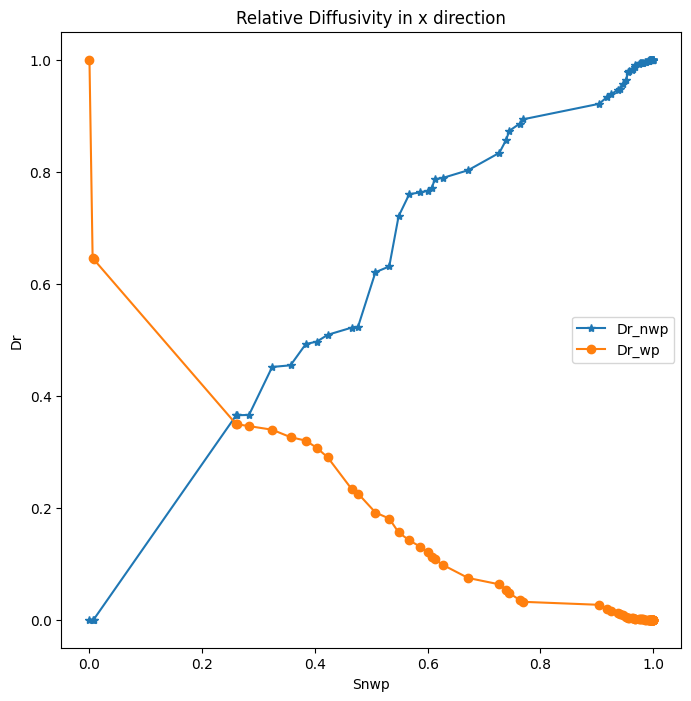

In [11]:
plt.figure(figsize=[8,8])
plt.plot(Snwparr, reldiff_nwp, '*-', label='Dr_nwp')
plt.plot(Snwparr, reldiff_wp, 'o-', label='Dr_wp')
plt.xlabel('Snwp')
plt.ylabel('Dr')
plt.title('Relative Diffusivity in x direction')
plt.legend()